In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.greedy_agent import GreedyAgent
from agentfil import constants
from mechafil import minting, sim

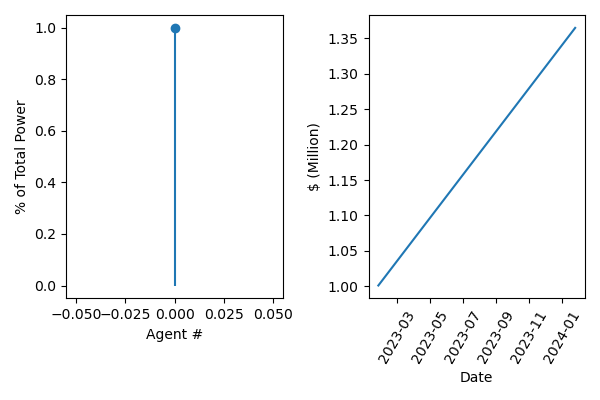

In [3]:
simulation_start_date = datetime.today().date() - timedelta(days=1)
forecast_length = 365
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 1
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.5)

# setup agent capital distributions. Proportion them in the same way as the power
starting_capital_usd = 1_000_000
capital_inflow_rate = 1000
total_capital_vec = np.arange(1,forecast_length+1) * capital_inflow_rate
total_capital_vec = total_capital_vec + starting_capital_usd
total_capital_df = pd.DataFrame({
    'date': pd.date_range(simulation_start_date, end_date, freq='D')[:-1],
    'USD': total_capital_vec
})
agent_accounting_df_vec = []
for ii, agent_power_pct in enumerate(agent_power_distributions):
    agent_accounting_df = total_capital_df.drop('date', axis=1)*agent_power_pct
    agent_accounting_df['date'] = total_capital_df['date']
    agent_accounting_df_vec.append(agent_accounting_df)

    
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
plt.stem(agent_power_distributions)
plt.xlabel('Agent #')
plt.ylabel('% of Total Power')

plt.subplot(1,2,2)
plt.plot(total_capital_df['date'], total_capital_df['USD']/starting_capital_usd)
plt.xticks(rotation=60)
plt.xlabel('Date')
plt.ylabel('\$ (Million)')

plt.tight_layout()

In [4]:
agent_types = [GreedyAgent] * num_agents
agent_kwargs_vec = []
for agent_accounting_df in agent_accounting_df_vec:
    kwargs = {
        'accounting_df': agent_accounting_df,
        'forecast_num_mc': 50,
        'agent_optimism': 4
    }
    agent_kwargs_vec.append(kwargs)
filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               agent_types, agent_kwargs_vec,
                               compute_cs_from_networkdatastart=True, use_historical_gas=False)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Fast forwarding power to simulation start date... 2023-01-26
Computing Scheduled Expirations from:  2023-01-26  to:  2024-01-25


In [5]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/365 [00:00<?, ?it/s]

In [6]:
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

agent1 = filecoin_model.agents[0]['agent']
agent1_df = agent1.agent_info_df
agent1_network_updates_df = agent1.accounting_df

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


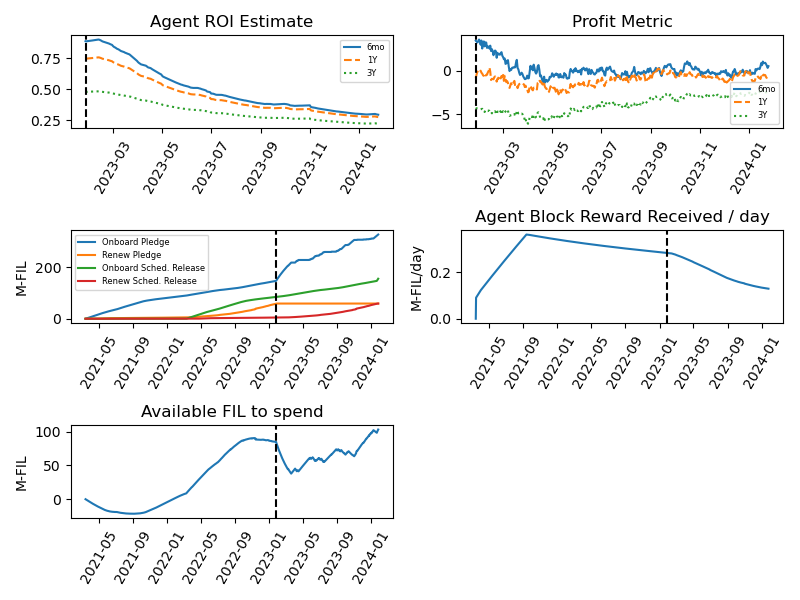

In [7]:
plt.figure(figsize=(8,6))
plt.subplot(3,2,1)
plt.plot(agent1_df['date'], agent1_df['roi_estimate_6mo'], label='6mo')
plt.plot(agent1_df['date'], agent1_df['roi_estimate_1y'], label='1Y', linestyle='--')
plt.plot(agent1_df['date'], agent1_df['roi_estimate_3y'], label='3Y', linestyle=':')
plt.xticks(rotation=60)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Agent ROI Estimate')
plt.legend(fontsize=6)

plt.subplot(3,2,2)
plt.plot(agent1_df['date'], agent1_df['profit_duration_6mo'], label='6mo')
plt.plot(agent1_df['date'], agent1_df['profit_duration_1y'], label='1Y', linestyle='--')
plt.plot(agent1_df['date'], agent1_df['profit_duration_3y'], label='3Y', linestyle=':')
plt.xticks(rotation=60)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Profit Metric')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
# plt.plot(agent1_df['date'], agent1_df['USD']-agent1_df['funds_used'].cumsum())
# plt.ylabel('$')
# plt.title('Agent Funds Available')
# .cumsum()/1_000_000
plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['onboard_pledge_FIL'].cumsum()/1_000_000, label='Onboard Pledge')
plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['renew_pledge_FIL'].cumsum()/1_000_000, label='Renew Pledge')
plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['onboard_scheduled_pledge_release_FIL'].cumsum()/1_000_000, label='Onboard Sched. Release')
plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['renew_scheduled_pledge_release_FIL'].cumsum()/1_000_000, label='Renew Sched. Release')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.legend(fontsize=6)

plt.subplot(3,2,4)
plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['reward_FIL']/1_000_000)
plt.xticks(rotation=60)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.ylabel('M-FIL/day')
plt.title('Agent Block Reward Received / day')

plt.subplot(3,2,5)
available_FIL_to_spend = agent1_network_updates_df['reward_FIL'].cumsum() \
                       - agent1_network_updates_df['onboard_pledge_FIL'].cumsum() \
                       - agent1_network_updates_df['renew_pledge_FIL'].cumsum() \
                       + agent1_network_updates_df['onboard_scheduled_pledge_release_FIL'].cumsum() \
                       + agent1_network_updates_df['renew_scheduled_pledge_release_FIL'].cumsum()
plt.plot(agent1_network_updates_df['date'], available_FIL_to_spend/1_000_000)
plt.xticks(rotation=60)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.ylabel('M-FIL')
plt.title('Available FIL to spend')

plt.tight_layout()

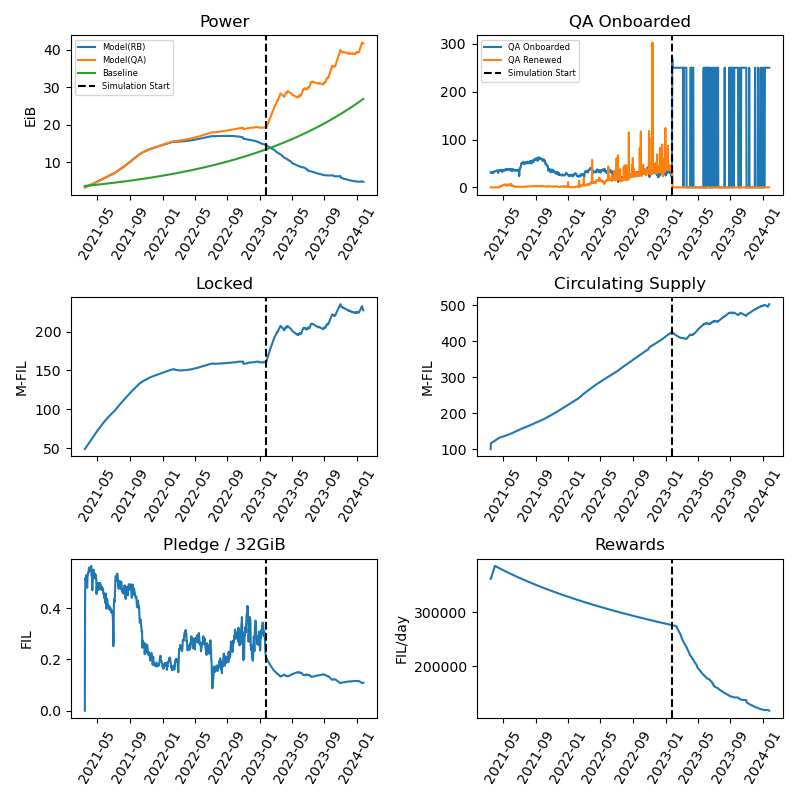

In [8]:
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='Model(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='Model(QA)')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(3,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='QA Onboarded')
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='QA Renewed')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Onboarded')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
# plt.plot(agent1_df_simsubset['date'], agent1_df_simsubset['roi_estimate_6mo'])
plt.plot(model_df['date'], model_df['network_locked']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')

plt.subplot(3,2,5)
plt.plot(model_df['date'], model_df['day_pledge_per_QAP'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')

plt.subplot(3,2,6)
plt.plot(model_df['date'], model_df['day_network_reward'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')


plt.tight_layout()

plt.show()